<a href="https://colab.research.google.com/github/yewentao256/CS5787-Final/blob/mitch-diffusion/inpainting_diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/scenery6000.zip'
extract_path = '/content/scenery6000'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to: {extract_path}")

Files extracted to: /content/scenery6000


In [ ]:
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch import nn
from torchvision import transforms
import random
import numpy as np
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import os

In [ ]:
class SceneryDataset(Dataset):
    def __init__(self, root_dir, image_size=(320, 512), mask_type='vertical', mask_size=128, blur=50, num_masks=25, transform=None):
        self.root_dir = root_dir
        self.image_files = [f for f in os.listdir(root_dir) if f.endswith('.jpg')]
        self.image_size = image_size
        self.mask_type = mask_type
        if mask_type == 'vertical':
            if not isinstance(mask_size, int):
                raise ValueError("mask_size must be an integer for 'vertical' mask type")
        elif mask_type == 'random':
            if not (isinstance(mask_size, tuple) and len(mask_size) == 2):
                raise ValueError("mask_size must be a tuple of two integers for 'random' mask type")
        self.mask_size = mask_size
        self.transform = transform if transform else transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
        self.blur = blur
        self.num_masks = num_masks
        self.masks = self.precompute_masks()

    def __len__(self):
        return len(self.image_files)


    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        mask = self.masks[idx % self.num_masks]
        # Do not apply the mask here; return the original image and mask
        return image, mask


    def create_mask(self):
        if self.mask_type == 'vertical':
            return self.create_vertical_mask()
        elif self.mask_type == 'random':
            return self.create_random_mask()

    def precompute_masks(self):
        masks = []
        for _ in range(self.num_masks):
            mask = self.create_mask()
            masks.append(torch.tensor(mask))
        return torch.stack(masks)


    def gaussian_blur(self, mask):
        edges = np.abs(np.gradient(mask, axis=(0, 1))).sum(axis=0)
        edge_mask = (edges > 0).astype(np.float32)
        blurred_edges = gaussian_filter(edge_mask, sigma=self.blur)
        return np.clip(mask + blurred_edges, 0, 1)

    def create_vertical_mask(self):
        mask = np.ones(self.image_size, dtype=np.float32)
        if self.num_masks == 1:
            height, width = self.image_size
            left = width // 2 - self.mask_size // 2
        else:
            left = random.randint(0, self.image_size[1] - self.mask_size)
        right = left + self.mask_size
        mask[:, left:right] = 0
        blur = self.gaussian_blur(mask)
        return (blur - np.min(blur)) / (np.max(blur) - np.min(blur))

    def create_random_mask(self):
        mask = np.ones(self.image_size, dtype=np.float32)
        top = random.randint(0, self.image_size[0] - self.mask_size[0])
        left = random.randint(0, self.image_size[1] - self.mask_size[1])
        mask[top:top+self.mask_size[0], left:left+self.mask_size[1]] = 0
        blur = gaussian_filter(mask, sigma=self.blur)
        return (blur - np.min(blur)) / (np.max(blur) - np.min(blur))

    def show_img(self, idx):
        image, mask = self.__getitem__(idx)
        image = (image * 0.5 + 0.5).permute(1, 2, 0).numpy()

        plt.imshow(image)
        plt.show()
        plt.imshow(image * masks[0].unsqueeze(2).numpy())
        plt.show()

img_folder = '/content/scenery6000/scenery/all'
dataset = SceneryDataset(img_folder, num_masks=1)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [ ]:
for batch_idx, (images, masks) in enumerate(dataloader):
    print(f"Batch {batch_idx + 1}")
    print("Images shape:", images.shape)  # [B, C, H, W]
    print("Masks shape:", masks.shape)    # [B, H, W]
    break

Batch 1
Images shape: torch.Size([16, 3, 320, 512])
Masks shape: torch.Size([16, 320, 512])


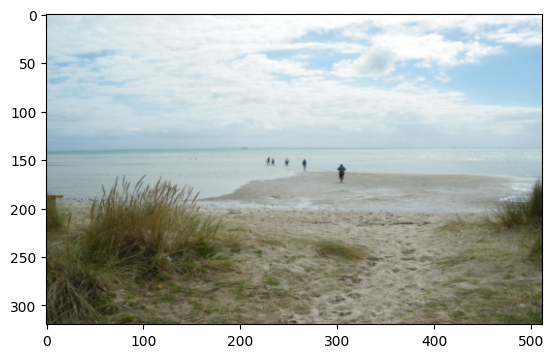

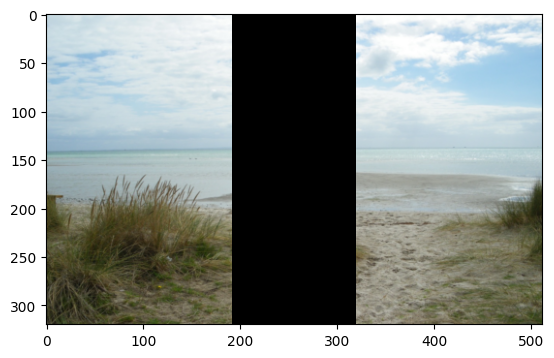

In [ ]:
dataset.show_img(500)

In [ ]:
images[0]

tensor([[[-0.9922, -0.9922, -1.0000,  ..., -0.8353, -0.8667, -0.8980],
         [-1.0000, -0.9922, -1.0000,  ..., -0.8353, -0.8824, -0.8353],
         [-1.0000, -0.9922, -0.9922,  ..., -0.7961, -0.8196, -0.8196],
         ...,
         [-0.7176, -0.6784, -0.6627,  ..., -0.4980, -0.5137, -0.5373],
         [-0.7020, -0.6784, -0.6784,  ..., -0.3490, -0.4039, -0.4902],
         [-0.7020, -0.7098, -0.6941,  ..., -0.3255, -0.3490, -0.4431]],

        [[-0.7412, -0.7569, -0.7647,  ..., -0.3725, -0.3725, -0.3804],
         [-0.7725, -0.7804, -0.7412,  ..., -0.3804, -0.3490, -0.3804],
         [-0.7490, -0.7490, -0.7569,  ..., -0.3961, -0.3569, -0.3804],
         ...,
         [-0.8667, -0.8588, -0.8588,  ..., -0.6157, -0.6784, -0.7176],
         [-0.8980, -0.8824, -0.8667,  ..., -0.4667, -0.5294, -0.6078],
         [-0.8902, -0.8588, -0.8510,  ..., -0.4745, -0.4980, -0.6078]],

        [[-0.2706, -0.2314, -0.1843,  ...,  0.0824,  0.0588,  0.0902],
         [-0.1765, -0.1765, -0.1686,  ...,  0

In [ ]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x, t_emb):
        # x: input feature map
        # t_emb: time embedding vector (batch_size, time_emb_dim)
        h = self.conv1(x)
        # Add time embedding
        time_emb = self.time_mlp(t_emb)
        time_emb = time_emb[:, :, None, None]  # Reshape to (batch_size, out_channels, 1, 1)
        h = h + time_emb
        h = self.bn1(h)
        h = self.relu(h)
        h = self.conv2(h)
        h = self.bn2(h)
        h = self.relu(h)
        return h

class Unet(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim=128, dims=[64, 128, 256, 512]):
        super().__init__()
        self.dims = dims
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        in_ch = in_channels

        # Encoder blocks
        for dim in dims:
            self.encoders.append(Block(in_ch, dim, time_emb_dim))
            in_ch = dim

        # Bottleneck
        self.bottleneck = Block(dims[-1], dims[-1] * 2, time_emb_dim)

        # Decoder blocks
        prev_channels = dims[-1] * 2  # Starting from bottleneck's output channels
        for dim in reversed(dims):
            # Upsampling layer
            self.decoders.append(nn.ConvTranspose2d(prev_channels, dim, kernel_size=2, stride=2))
            # Decoder block
            self.decoders.append(Block(dim * 2, dim, time_emb_dim))
            prev_channels = dim  # Update for next iteration

        self.out_conv = nn.Conv2d(dims[0], out_channels, kernel_size=1)

    def forward(self, x, t_emb):
        skip_connections = []

        # Encoder path
        for encoder in self.encoders:
            x = encoder(x, t_emb)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x, t_emb)
        skip_connections = skip_connections[::-1]

        # Decoder path
        for i in range(0, len(self.decoders), 2):
            # Upsampling
            x = self.decoders[i](x)  # ConvTranspose2d layer
            skip_connection = skip_connections[i // 2]

            # Ensure that the shapes match before concatenation
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:])

            # Concatenate with skip connection
            x = torch.cat((skip_connection, x), dim=1)

            # Decoder block with time embedding
            x = self.decoders[i + 1](x, t_emb)

        x = self.out_conv(x)
        return x

In [ ]:
import math
class PositionalEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time_steps):
        device = time_steps.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = time_steps[:, None] * emb[None, :]
        emb = torch.cat((torch.sin(emb), torch.cos(emb)), dim=-1)
        return emb

class Diffusion(nn.Module):
    def __init__(self, timesteps=1000, beta_start=1e-4, beta_end=0.02, device='cuda'):
        super().__init__()
        self.timesteps = timesteps
        self.unet = Unet(4, 3).to(device)
        self.device = device
        self.beta = torch.linspace(beta_start, beta_end, timesteps).to(device)
        self.alpha = 1 - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.time_embedding = PositionalEmbeddings(128)

    def add_noise(self, x, t):
        alpha_t = self.alpha_bar[t][:, None, None, None] #reshape to match x
        noise = torch.randn_like(x)
        x_t = torch.sqrt(alpha_t) * x + torch.sqrt(1 - alpha_t) * noise
        return x_t, noise

    def forward(self, x, mask, t):
        mask = mask.unsqueeze(1)
        t_embed = self.time_embedding(t)
        x = torch.cat([x, mask], dim=1)
        return self.unet(x, t_embed)

    def sample(self, x, mask):
        x_noise = torch.randn_like(x).to(self.device)
        mask = mask.unsqueeze(1)
        for t in range(self.timesteps - 1, -1, -1):
            t_tensor = torch.full((x.shape[0],), t, device=self.device, dtype=torch.long)
            # Enforce known regions
            x_noise = x_noise * (1 - mask) + x * mask
            pred = self.forward(x_noise, mask.squeeze(1), t_tensor)
            alpha_t = self.alpha[t].to(self.device)
            alpha_bar_t = self.alpha_bar[t].to(self.device)
            beta_t = self.beta[t].to(self.device)

            x_noise = (1 / torch.sqrt(alpha_t)) * (x_noise - beta_t / torch.sqrt(1 - alpha_bar_t) * pred)

            if t > 0:
                noise = torch.randn_like(x_noise).to(self.device)
                x_noise += torch.sqrt(beta_t) * noise

        # Final enforcement of known regions
        x_noise = x_noise * (1 - mask) + x * mask
        return x_noise

In [ ]:
def train(model, dataloader, optimizer, loss_fn, device, num_epochs):
    model.train()
    min_loss = 100
    increased = 0
    for epoch in range(num_epochs):
        for batch_idx, (images, masks) in enumerate(dataloader):
            optimizer.zero_grad()
            images, masks = images.to(device), masks.to(device)
            t = torch.randint(0, model.timesteps, (images.size(0),), device=device)

            # Add noise only to masked regions
            x_noisy, noise = model.add_noise(images, t)
            masks_unsqueezed = masks.unsqueeze(1)
            x_t = images * masks_unsqueezed + x_noisy * (1 - masks_unsqueezed)

            # Model prediction
            outputs = model(x_t, masks, t)

            # Compute loss only over masked regions
            loss = loss_fn(outputs * (1 - masks_unsqueezed), noise * (1 - masks_unsqueezed))
            loss.backward()
            optimizer.step()

            if batch_idx % 50 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Batch [{batch_idx + 1}/{len(dataloader)}], Loss: {loss.item():.4f}")
                if loss.item() < min_loss:
                    min_loss = loss.item()
                    increased = 0
                else:
                    increased += 1

                if increased > 5:
                    print('Early stopping')
                    return

        # print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

model = Diffusion().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()
train(model, dataloader, optimizer, loss_fn, 'cuda', 20)

Epoch [1/20], Batch [1/363], Loss: 0.2946
Epoch [1/20], Batch [51/363], Loss: 0.0638
Epoch [1/20], Batch [101/363], Loss: 0.0257
Epoch [1/20], Batch [151/363], Loss: 0.0304
Epoch [1/20], Batch [201/363], Loss: 0.0156
Epoch [1/20], Batch [251/363], Loss: 0.0179
Epoch [1/20], Batch [301/363], Loss: 0.0222
Epoch [1/20], Batch [351/363], Loss: 0.0308
Epoch [2/20], Batch [1/363], Loss: 0.0220
Epoch [2/20], Batch [51/363], Loss: 0.0169
Epoch [2/20], Batch [101/363], Loss: 0.0133
Epoch [2/20], Batch [151/363], Loss: 0.0210
Epoch [2/20], Batch [201/363], Loss: 0.0083
Epoch [2/20], Batch [251/363], Loss: 0.0083
Epoch [2/20], Batch [301/363], Loss: 0.0079
Epoch [2/20], Batch [351/363], Loss: 0.0073
Epoch [3/20], Batch [1/363], Loss: 0.0144
Epoch [3/20], Batch [51/363], Loss: 0.0304
Epoch [3/20], Batch [101/363], Loss: 0.0173
Epoch [3/20], Batch [151/363], Loss: 0.0145
Epoch [3/20], Batch [201/363], Loss: 0.0065
Epoch [3/20], Batch [251/363], Loss: 0.0080
Epoch [3/20], Batch [301/363], Loss: 0.02

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/diffusion_model.pth')

In [ ]:
# Load the model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Diffusion().to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/diffusion_model.pth', map_location=device))
model.eval()  # Set the model to evaluation mode
dataloader_pred = DataLoader(dataset, batch_size=4, shuffle=True)
print("Model loaded successfully.")

<ipython-input-29-f48a939c5af3>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/diffusion_model.pth', map_location=

Model loaded successfully.


In [ ]:
def generate_inpainted_images(
    model,
    original_images,
    masks,
    num_images=4,
    device='cuda',
    save_path=None
):
    # Ensure the model is in evaluation mode
    model.eval()

    # Limit to num_images if more are provided
    original_images = original_images[:num_images]
    masks = masks[:num_images]

    # Ensure masks have the right shape
    if masks.dim() == 2:
        masks = masks.unsqueeze(0)

    # Convert masks to float if needed
    masks = masks.float()

    # Move inputs to the specified device
    original_images = original_images.to(device)
    masks = masks.to(device)

    # Disable gradient computation for inference
    with torch.no_grad():
        # Generate inpainted images
        generated_images = model.sample(original_images, masks)

    # Denormalize images for visualization
    generated_images = generated_images * 0.5 + 0.5

    # Optional: Save generated images
    if save_path and os.path.isdir(save_path):
        os.makedirs(save_path, exist_ok=True)
        for i, img in enumerate(generated_images):
            # Convert tensor to PIL Image
            img_np = img.permute(1, 2, 0).cpu().numpy()
            img_pil = Image.fromarray((img_np * 255).astype(np.uint8))
            img_pil.save(os.path.join(save_path, f'inpainted_image_{i}.png'))

    return generated_images

def visualize_inpainting(
    model,
    dataloader,
    device='cuda',
    num_images=4,
    save_path=None
):
    """
    Visualize inpainting results from a dataloader.

    Parameters:
    - model: Trained Diffusion model
    - dataloader: DataLoader containing masked images and masks
    - device: Device to run the model on
    - num_images: Number of images to generate/display
    - save_path: Optional path to save generated images

    Returns:
    - Tuple of (original masked images, generated images)
    """
    # Get a batch of data
    original_masked_images, masks = next(iter(dataloader))

    # Generate inpainted images
    generated_images = generate_inpainted_images(
        model,
        original_masked_images,
        masks,
        num_images=num_images,
        device=device,
        save_path=save_path
    )

    # Optional visualization
    if save_path:
        plt.figure(figsize=(15, 10))
        for i in range(num_images):
            plt.subplot(3, num_images, i+1)
            original_img = (original_masked_images[i] * 0.5 + 0.5).permute(1, 2, 0).numpy()
            plt.imshow(original_img)
            plt.title('Original Image')
            plt.axis('off')

            masked_img = original_img * masks[i].unsqueeze(2).numpy()
            plt.subplot(3, num_images, num_images+i+1)
            plt.imshow(masked_img)
            plt.title('Masked Image')
            plt.axis('off')

            plt.subplot(3, num_images, 2*num_images+i+1)
            gen_img = generated_images[i].permute(1, 2, 0).cpu().numpy()
            plt.imshow(gen_img)
            plt.title('Inpainted Image')
            plt.axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(os.path.join(save_path, 'inpainting_comparison.png'))
        plt.show()

    return original_masked_images, generated_images

In [ ]:
# for batch_idx, (images, masks) in enumerate(dataloader_pred):
#     print(f"Batch {batch_idx + 1}")
#     print("Images shape:", images.shape)  # [B, C, H, W]
#     print("Masks shape:", masks.shape)
#     break

In [ ]:
masks.unsqueeze(1).expand(-1, 3, -1, -1).shape

torch.Size([16, 3, 320, 512])

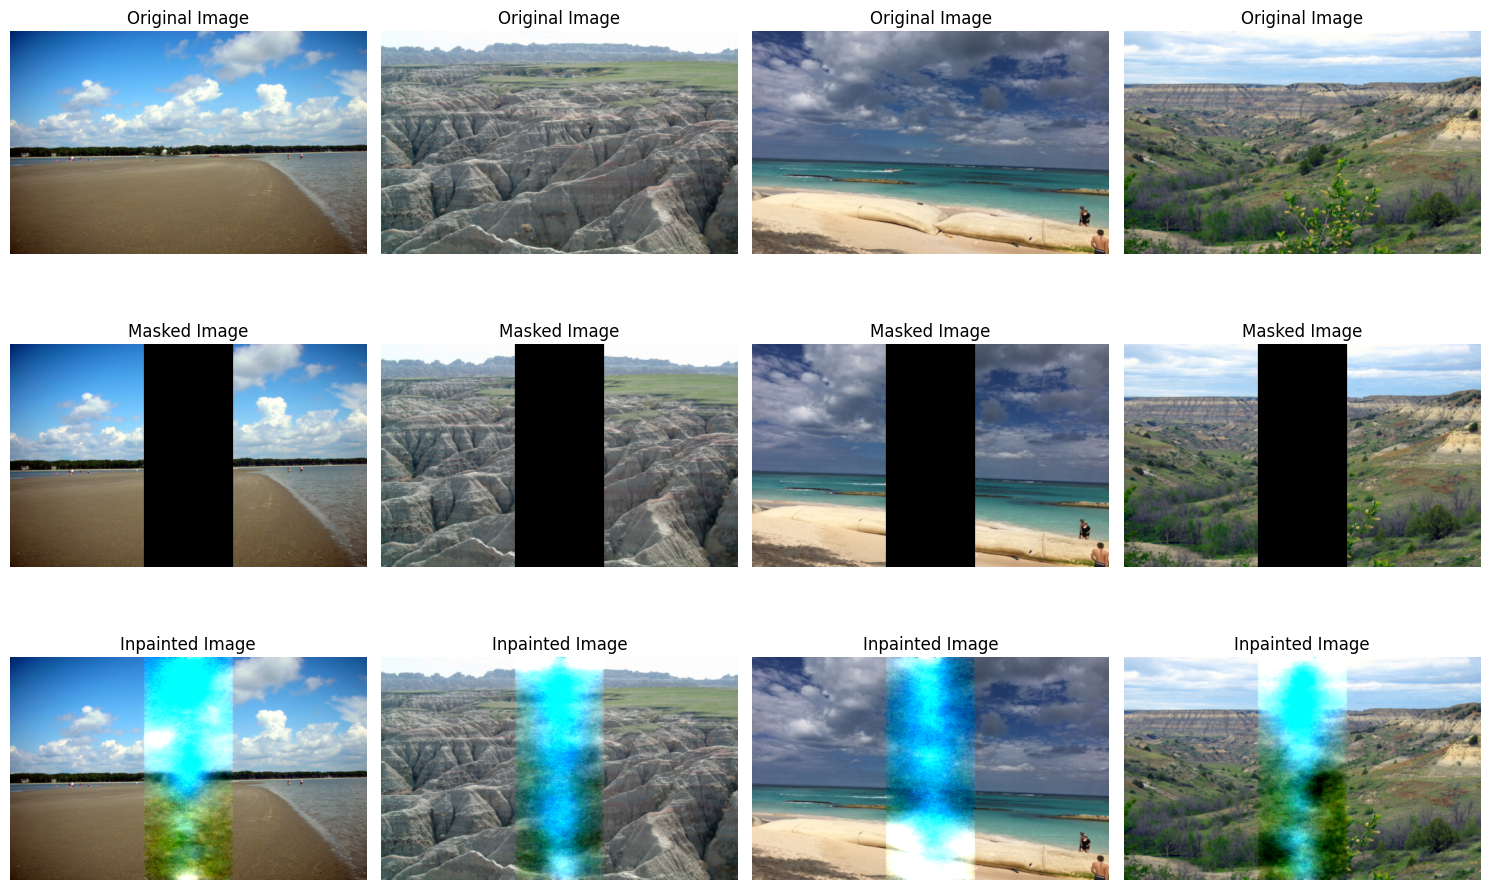

In [ ]:
# Set up directories
base_dir = '/content/drive/MyDrive/inpainting_results'
os.makedirs(base_dir, exist_ok=True)

# Image folder (same as before)
img_folder = '/content/scenery6000/scenery/all'

original_masked, generated = visualize_inpainting(
        model,
        dataloader,
        device='cuda',
        num_images=4,
        save_path=base_dir
    )


In [ ]:
img_folder = '/content/drive/MyDrive/scenery_test'
dataset_test = SceneryDataset(img_folder, num_masks=1)
dataloader_test = DataLoader(dataset_test, batch_size=4, shuffle=False)

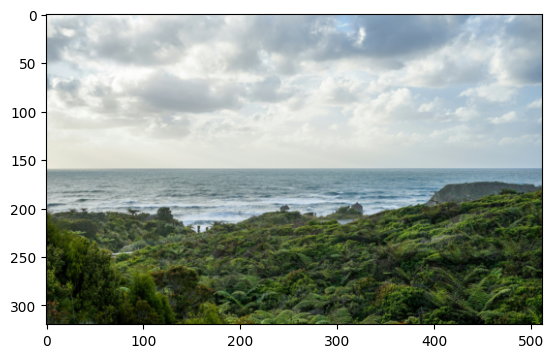

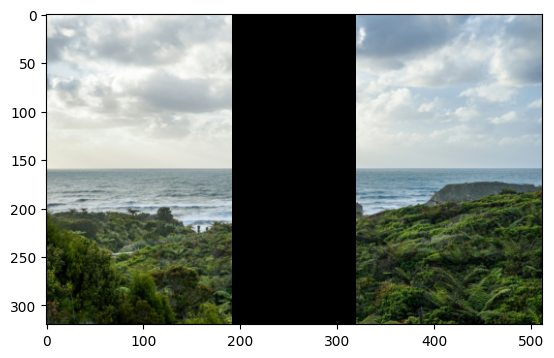

In [ ]:
dataset_test.show_img(1)

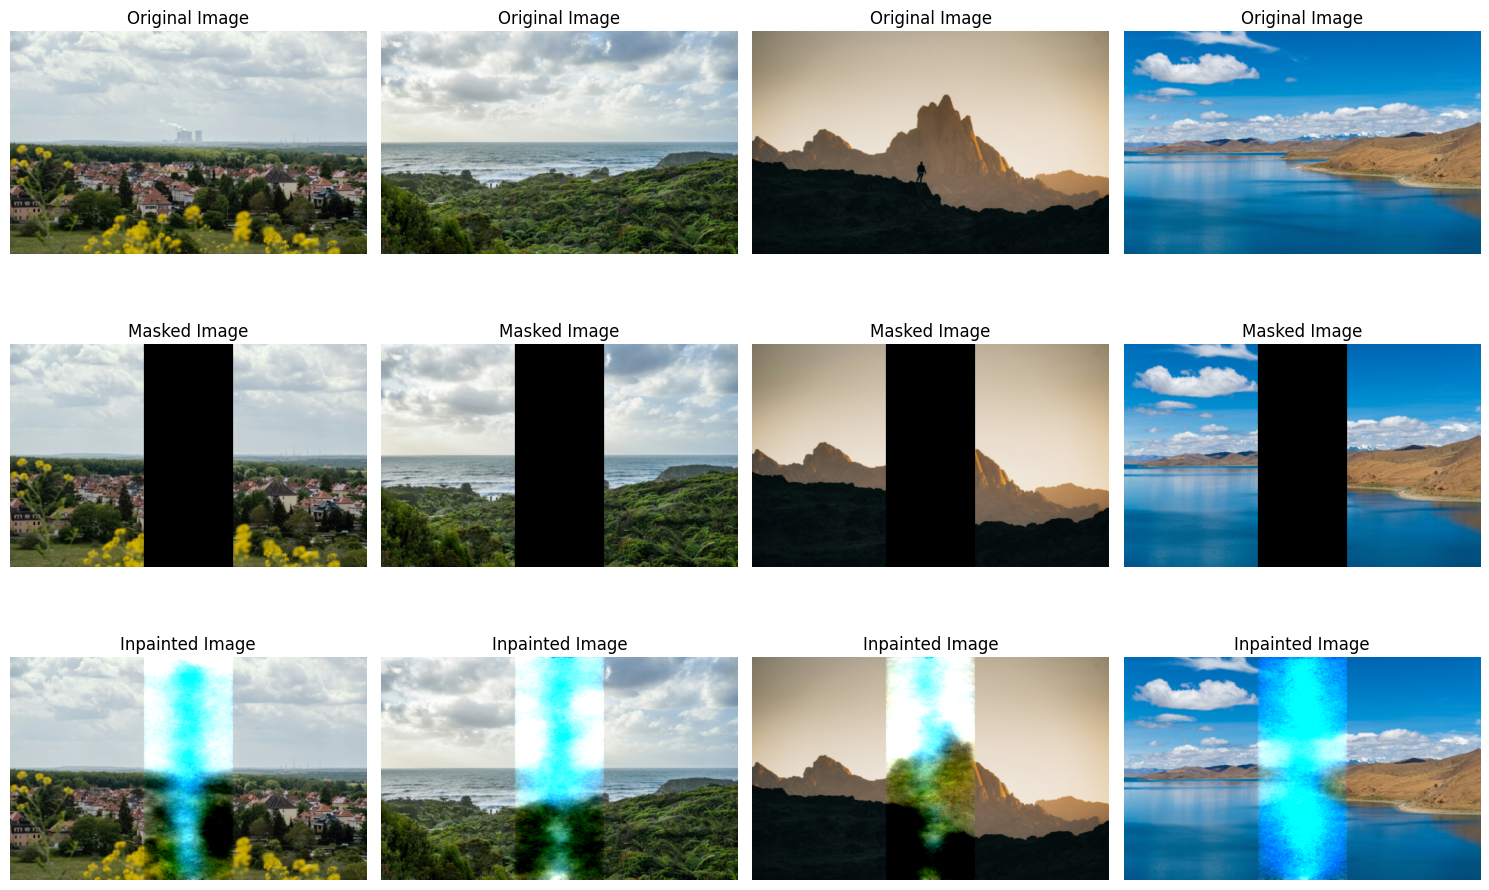

In [ ]:
# Set up directories
base_dir = '/content/drive/MyDrive/inpainting_results_test'
os.makedirs(base_dir, exist_ok=True)

# Image folder (same as before)
img_folder = '/content/drive/MyDrive/scenery_test'

original_masked, generated = visualize_inpainting(
        model,
        dataloader_test,
        device='cuda',
        num_images=4,
        save_path=base_dir
    )
